In [1]:
%run pylib/diffuse dark
from pylib.ipynb_docgen import *
show('<font size="+4"> Galactic diffuse study</font>')
show_date()

<font size="+4"> Galactic diffuse study</font>

<h5 style="text-align:right; margin-right:15px"> 2024-10-26 15:25</h5>

In [ ]:
show(f""" Definition of the galacticity $G$:""")
show("$G(\mathbf{n})= \log_{10}(F(E=1 GeV, \mathbf{n}))$")
show(r"""Units of the flux $F=E^2\ \frac{dN}{dE}$: $\mathrm{eV\ cm^{-2}\ s^{-1}\ deg^{-2}}$""")

In [3]:
ds =DiffuseSED()
show(f"""## Diffuse SED plots for $l=0$""")

## Diffuse SED plots for $l=0$

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f30d504dc90>
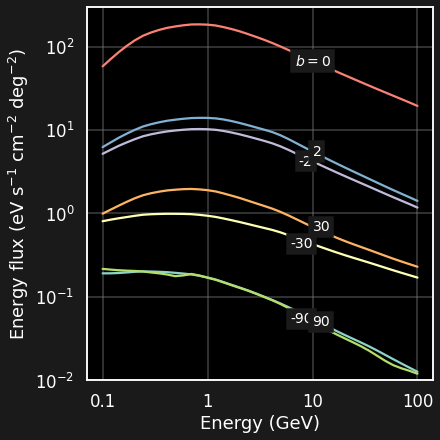

In [4]:
show_fig(ds.eflux_plot,  l=0, facecolor='k',save_to='figures/diffuse/diffuse_sed.png');

## SED value at $E=1$ GeV

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f30d4f95600>
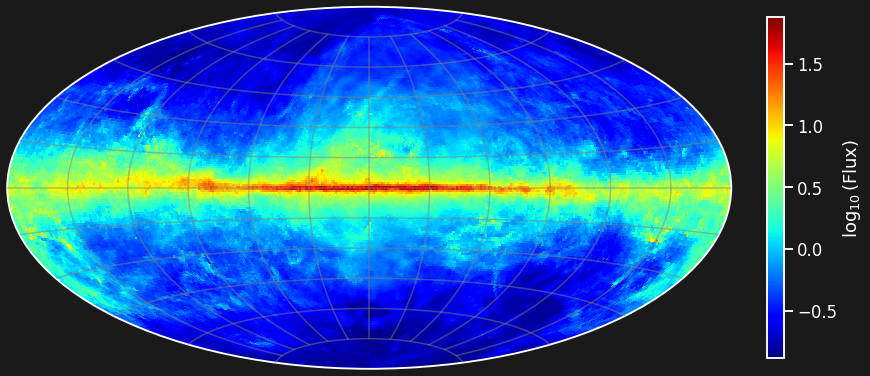

In [5]:
show(f"""## SED value at $E={(E:=1)}$ GeV""")
show_fig( DiffuseSED.ait_plot, energy=E*1e3, nside=128, 
         fig=plt.figure(figsize=(12,6)),
         facecolor='k', save_to='figures/diffuse/ait.png');

In [6]:
show(f"""## Make a map of curvature""")
from astropy.coordinates import SkyCoord
import healpy

nside=64
lb = healpy.pix2ang(nside, range(12*nside**2), lonlat=True)
sc = SkyCoord(*lb, unit='deg', frame='galactic')
def lppar(s):
    sed = ds.sed(s)
    return np.array([np.exp(sed.max()),sed.curvature()])
%time cc = np.array([lppar(s) for s in sc]).T

## Make a map of curvature

CPU times: user 1min 8s, sys: 89.6 ms, total: 1min 8s
Wall time: 1min 8s


## Curvature vs. peak Energy

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f30d4f220b0>
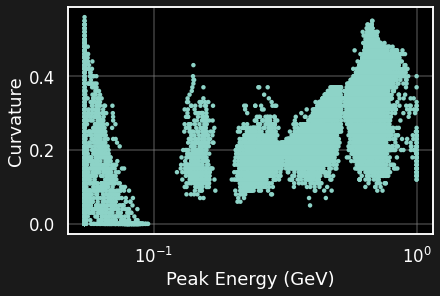

In [7]:
show(f"""## Curvature vs. peak Energy""")
def curvature_vs_energy():
    fig, ax = plt.subplots(figsize=(6,4))
    sns.scatterplot(ax=ax,x=cc[0].clip(0,1000)/1e3,y=cc[1].clip(0,1), s=20, edgecolor='none')
    ax.set(xscale='log', xlabel='Peak Energy (GeV)',ylabel='Curvature' )
    return fig
show_fig(curvature_vs_energy, save_to='figures/diffuse/curvature_vs_energy.png', facecolor='k')

### Curvature map

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f30d504e140>
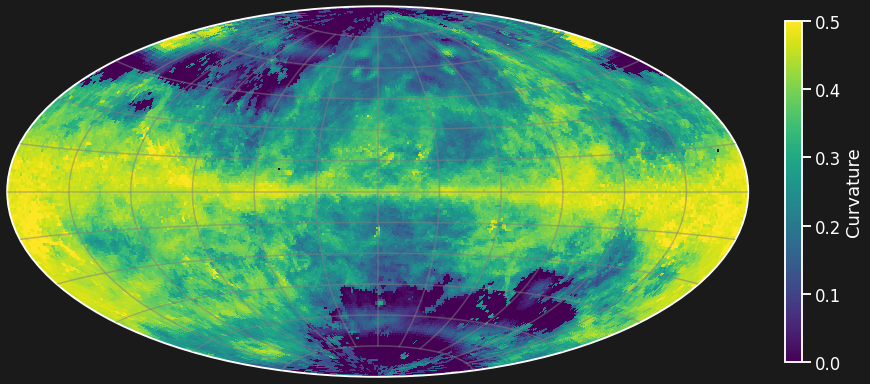

In [8]:
show(f"""### Curvature map""")
def curvature_ait_map():
    return (AITfigure(figsize=(12,6))
     .imshow(cc[1], cmap='viridis', vmin=0, vmax=0.5)
     .colorbar(shrink=0.8, label='Curvature', )
    ).figure

show_fig(curvature_ait_map, save_to='figures/diffuse/curvature_ait_map.png', 
         facecolor='k' )

In [9]:
import pandas as pd
show(f"""# Load data 
* Load source data from `{(filename:='files/dr4_2_class_3_features.csv')}'""")
all_data = pd.read_csv( 'files/kde_data.csv',index_col=0)
all_data['G']= all_data.diffuse # for convenience
subgrp = all_data.groupby('subset')
show(pd.Series(subgrp.size(),name='Souces'))
unid = subgrp.get_group('unID').copy()

# Load data 
* Load source data from `files/dr4_2_class_3_features.csv'

subset,blazar,msp,psr,unID
Souces,2283,176,140,2205


In [10]:
show(f"""## Add diffuse shape info to unid""")
def curvature(rec):
    sc = SkyCoord(rec.glon, rec.glat, unit='deg', frame='galactic')
    sed =ds.sed(sc)
    return np.array((sed.curvature(), np.exp(sed.max())))
    
t = np.array([curvature(rec) for name, rec in unid.iterrows()]).T

unid['G_curv'] = t[0]
unid['G_max']  = t[1]

## Add diffuse shape info to unid

## Examine diffuse spectral properties at unID positions

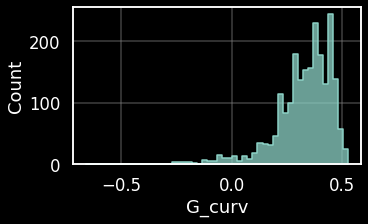

In [11]:
show(f"""## Examine diffuse spectral properties at unID positions""")
sns.histplot(unid, x='G_curv', element='step');
plt.show()

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f30d1203d30>
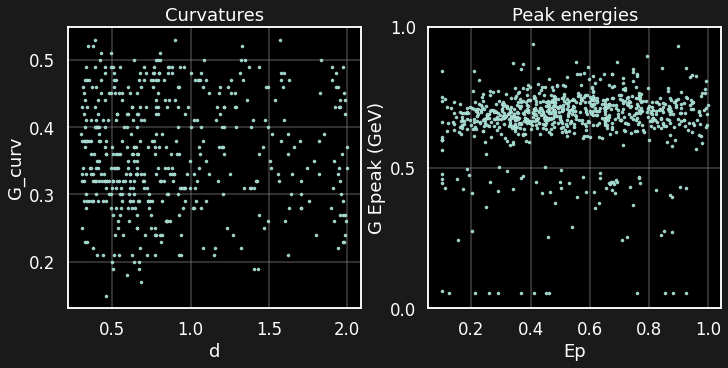

In [12]:
def G_correlations(unid):
    fig, axx = plt.subplots(ncols=2, figsize=(10,5))
    # sns.scatterplot(unid,ax=axx[0,0], x='G', y=unid.G_curv.clip(0,1), s=10);
    # sns.scatterplot(unid,ax=axx[0,1], x='G_max', y=unid.G_curv.clip(0,1), s=10);
    sns.scatterplot(unid.query('0<G<1'), ax=axx[0], x='d', 
                    y=unid.G_curv.clip(0,1), s=10).set_title('Curvatures')
    sns.scatterplot(unid.query('0<G<1'), ax=axx[1], 
                    x=unid.Ep.clip(0.1,5), y=unid.G_max/1e3, s=10).set_title('Peak energies')
    axx[1].set( ylim=(0.1,1), ylabel='G Epeak (GeV)', yticks=np.arange(0,1.1,0.5) )
    return fig
show_fig(G_correlations, unid.query('d>0.3 & Ep<1'), facecolor='k',
         save_to='figures/diffuse/G_correlations.png')

# Blazar G distribution  

<pylib.ipynb_docgen.doc_formatter.<locals>.MimeBundleObject at 0x7f30d129ea10>
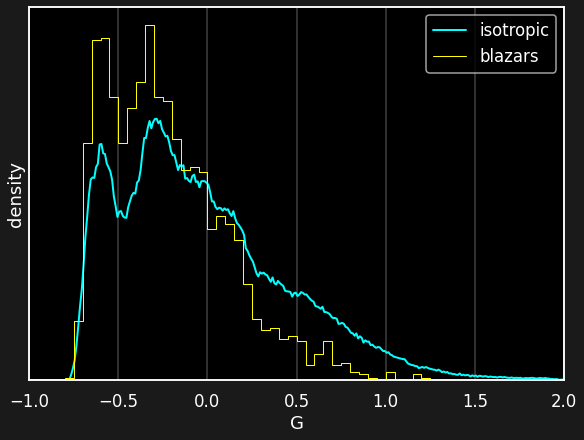

Need to account for detection

In [13]:
show(f"""# Blazar G distribution  """)
# %run pylib/diffuse dark
def compare_iso_agn():
    ls = IsotropicDiffuse()#reload=True, binsize=0.01)
    fig, ax = plt.subplots(figsize=(8,6), )
    ax.plot(ls.cache.gx, ls.cache.gy, label='isotropic', lw=2, color='cyan');
    sns.histplot(subgrp.get_group('blazar'), ax=ax, x='G', 
                 bins=np.arange(-1,2, 0.05), stat='density', element='step', fill=False,
                label='blazars', color='yellow', lw=1);
    ax.set(xlim=(-1,2), ylabel='density', yticks=[])
    ax.legend();
    return fig
show_fig(compare_iso_agn, facecolor='k', save_to='figures/diffuse/iso_and_agn.png')
show("""Need to account for detection""")

In [14]:
show(f""" # Use $G$ and $F_p$ to study treshold""")
show(f"""Number of blazars with cut {(cut:='Ep<10 & variability<30')}: {len(agn.query(cut))}""")


fig, ax = plt.subplots(figsize=(8,8))
sns.kdeplot(agn.query(cut), ax=ax, x='G',  y=agn.log_fpeak-agn.G,
                        # s=20, edgecolor='none',
            color='cyan', alpha=0.4 , label='blazar')
sns.scatterplot(unid, ax=ax, x='G', y=unid.log_fpeak-unid.G,#'log_fpeak', 
                        s=10, edgecolor='none', color='yellow', alpha=0.5, 
               label='unID')
ax.set(xlim=(-1,2))
ax.legend()
show(fig)

# Use $G$ and $F_p$ to study treshold

NameError: name 'agn' is not defined

In [ ]:
pulsar = all_data.query('association_class=="pulsar"') #subgrp.get_group('blazar')
show(f"""Number of pulsars with cut {(cut:='Ep<10 & variability<30')}: {len(pulsar.query(cut))}""")


fig, ax = plt.subplots(figsize=(8,8))
sns.kdeplot(pulsar.query(cut), ax=ax, x='G',  y=pulsar.log_fpeak-pulsar.G,
                        # s=20, edgecolor='none',
            color='cyan', alpha=0.4 , label='pulsar')
sns.scatterplot(unid, ax=ax, x='G', y=unid.log_fpeak-unid.G,#'log_fpeak', 
                        s=10, edgecolor='none', color='yellow', alpha=0.5, 
               label='unID')
ax.set(xlim=(-1,2), ylim=(-3,3), ylabel='log(adjusted flux)')
ax.legend()
show(fig)

In [ ]:
show(f"""### Project aflux with {(acut:='0<G<1.2')}""")
fig, ax = plt.subplots(figsize=(7,5))
hkw = dict(bins=np.arange(-3,3,0.2), element='step', fill=True, alpha=0.15, lw=2, stat='density')
sns.histplot(pulsar.query(acut), ax=ax, x =pulsar.log_fpeak-pulsar.G, label='pulsar',**hkw)
sns.histplot(unid.query(acut),ax=ax, x =unid.log_fpeak-unid.G, label='unID',**hkw)
ax.set(xlabel='log(Adjusted flux)', xlim=(-3,3))
ax.legend(frameon=False);
show(fig);

In [ ]:
show(f"""### Significance?""")
fig, ax = plt.subplots(figsize=(7,5))
hkw = dict(bins=np.arange(0.1,2.5,0.05),
           element='step', fill=True, alpha=0.15, lw=2, stat='density',)
sns.histplot(pulsar.query(acut), ax=ax, x =np.log10(pulsar.significance), label='pulsar',**hkw)
sns.histplot(unid.query(acut),ax=ax, x =np.log10(unid.significance), label='unID',**hkw)
ax.set(xlabel='log(significance)',)
ax.legend(frameon=False);
show(fig);

In [ ]:
%run pylib/kde_doc dark
galfuncs = GalFunctions(data)

In [ ]:
all_data.groupby('association_class').size()

In [ ]:
def populations_G():
    fig, ax = plt.subplots(figsize=(6,5))
    palette='coral cyan yellow'.split()
    hue_kw=dict(hue='source_type', hue_order='psr msp unID-pulsar'.split(),)
    
    # sns.kdeplot(all_data, ax=ax, x=all_data.G.clip(-1,2), **hue_kw,
    #            common_norm=True,   palette=palette,);
    sns.histplot(all_data, ax=ax, x=all_data.G.clip(-1,2), **hue_kw,stat='density', 
                 common_norm=True, palette=palette,
                 bins=np.arange(-1,2.01, 0.1), element='step', alpha=0.2,);
    sns.move_legend(ax, loc='upper left', fontsize=None, title='', frameon=False);
    ax.set(xlim=(-1,2), yticks=[]);
    ax.text(0.65, 0.04, '?', fontsize=64, color='r')
    return fig

show(f"""# G population plot""")
show_fig(populations_G, facecolor='k', 
         save_to='figures/diffuse/populations_G.png')

In [ ]:
from PIL import Image
from PIL.PngImagePlugin import PngInfo
show('https://stackoverflow.com/questions/58399070/how-do-i-save-custom-information-to-a-png-image-file-in-python')